# IE 423 PROJECT PART 2

## TASK 1

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import glob
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from scipy.stats import normaltest

We used data from 2018 to 2021 as historical data and calculated the profit we gained in 2021 by using pairs trading strategy.

In [25]:
files_2018_to_2021 = ["20180101_20180401_bist30.csv","20180402_20180701_bist30.csv","20180702_20180930_bist30.csv","20181001_20181230_bist30.csv","20181231_20190331_bist30.csv","20190401_20190630_bist30.csv","20190701_20190929_bist30.csv","20190930_20191229_bist30.csv","20191230_20200329_bist30.csv","20200330_20200628_bist30.csv","20200629_20200927_bist30.csv","20200928_20201227_bist30.csv"]
df_list = []

for file in files_2018_to_2021:
    df = pd.read_csv(file)
    df_list.append(df)

df = pd.concat(df_list, ignore_index=True)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)
df = df.sort_values(by="timestamp")


First, we divided the data into individual stocks and put them into a dataframe called "all_df". Since price data was not stationary, to be able to analyze the data, we turned it into a stationary time series by taking the difference of every consecutive row. 

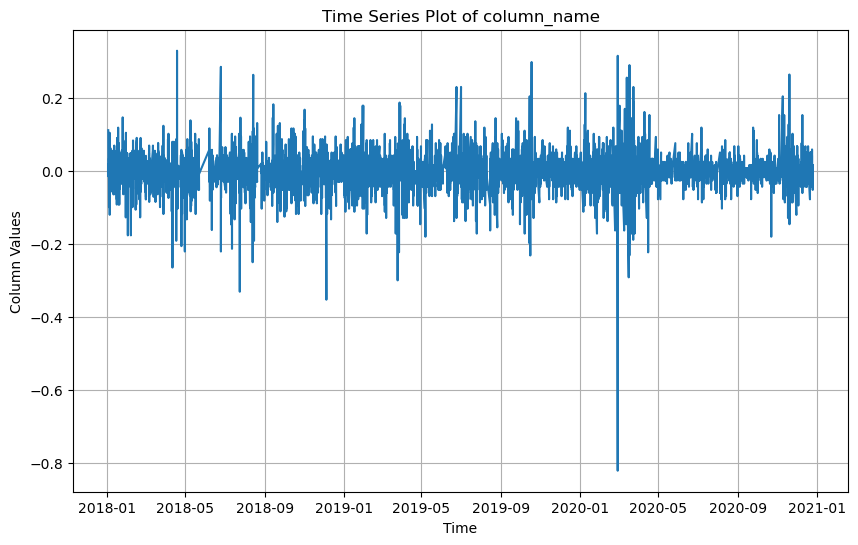

In [27]:
stock_names = df['short_name'].unique()
all_df = pd.DataFrame()
for stock in stock_names:
    stock_data = df.loc[df["short_name"] == stock].iloc[:,[0,1]]
    all_df[stock] = stock_data["price"]

all_df = all_df.diff().dropna()

plt.figure(figsize=(10, 6))
plt.plot(all_df['AKBNK'])
plt.title('Time Series Plot of column_name')
plt.xlabel('Time')
plt.ylabel('Column Values')
plt.grid(True)
plt.show()


After we made sure that the data looks stationary, we calculated the correlation coefficient between all stock pairs and created a heatmap to show which stocks are highly correlated.

<Axes: >

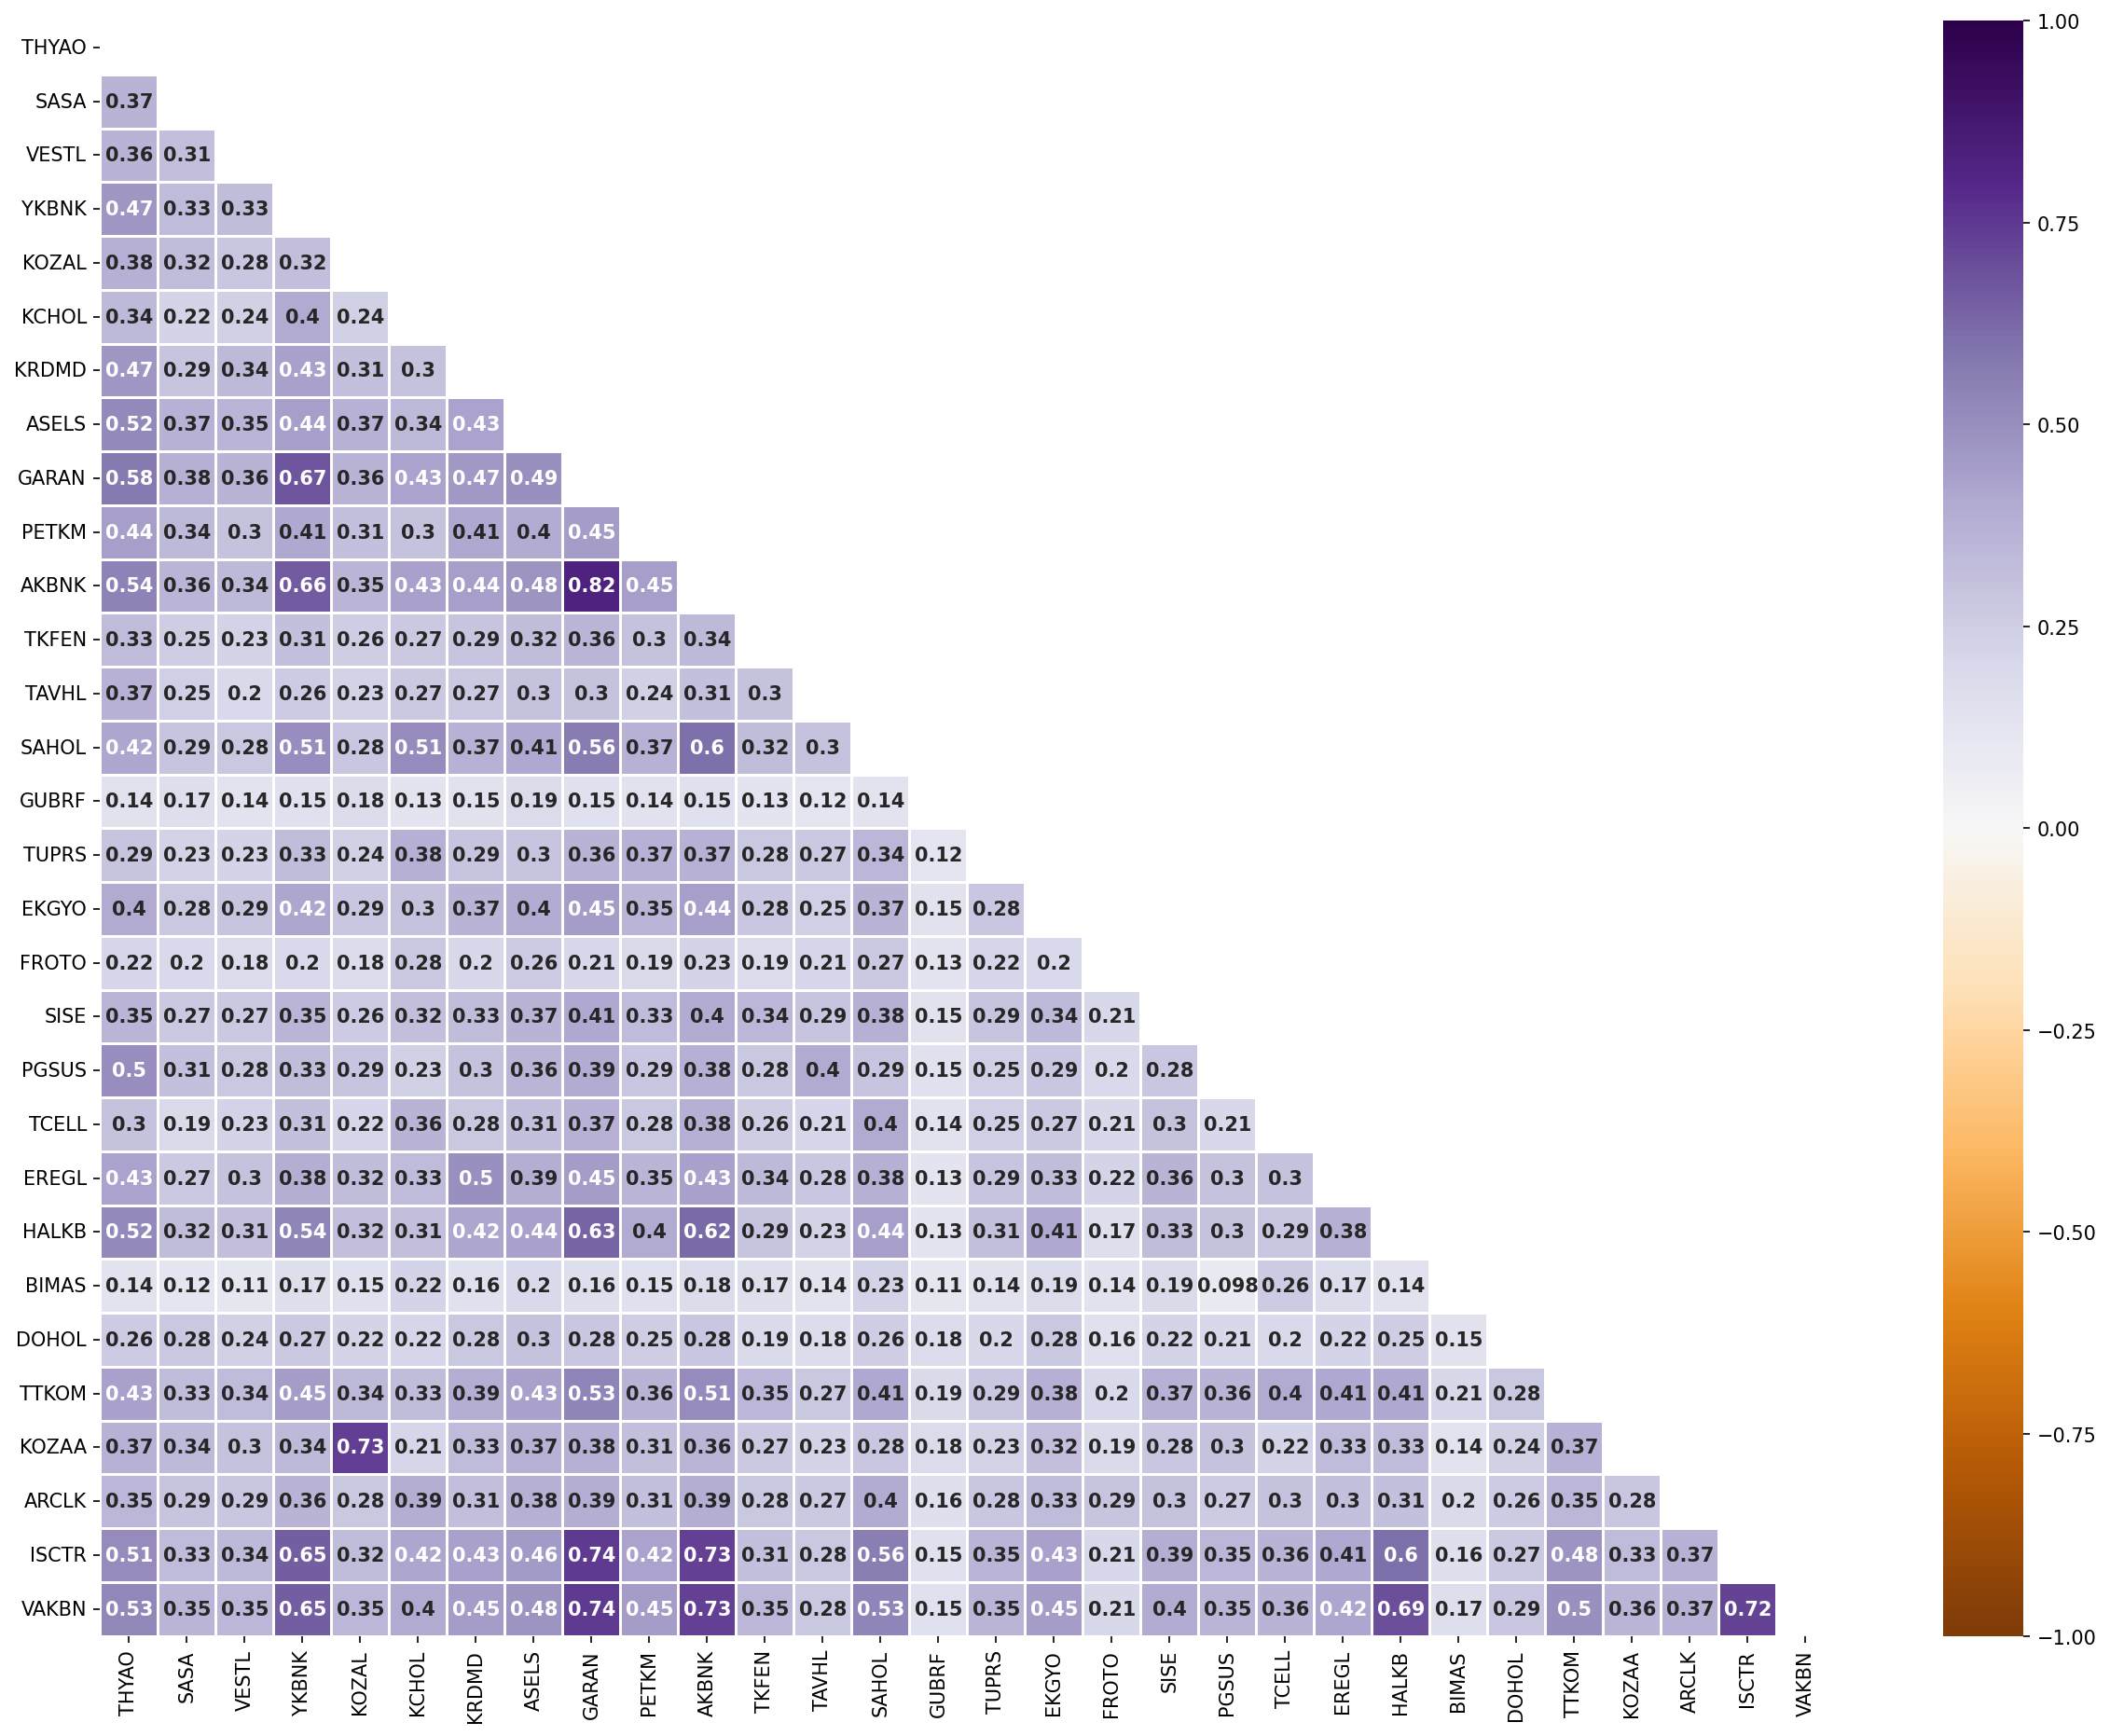

In [28]:
stock_names = df['short_name'].unique()
all_df = pd.DataFrame()
for stock in stock_names:
    stock_data = df.loc[df["short_name"] == stock].iloc[:,[0,1]]
    all_df[stock] = stock_data["price"]
    
all_df = all_df.interpolate().diff().dropna()
corr = all_df.corr()
matrix = np.triu(corr)
plt.figure(figsize=(20,15), dpi=150) 
sns.heatmap(corr,mask = matrix, vmin = -1, vmax = 1, linewidth = 0.5,cmap ="PuOr",annot = True,annot_kws ={'fontweight':'bold'})

We choose "AKBNK" and "GARAN" as our first stock pair due to their high correlation. We fit a regression line between these two stocks and calculated the residuals.

In [ ]:
X = all_df["AKBNK"].values.reshape(-1,1)
Y = all_df["GARAN"].values.reshape(-1,1)

lr = LinearRegression()
lr.fit(X,Y)
Y_predictions = lr.predict(X)
residuals = Y - Y_predictions
mean = residuals.mean()
std = residuals.std()

We checked if the residuals satisfy the constant variance assumption. Variance of the residuals remained constant through predicted values.

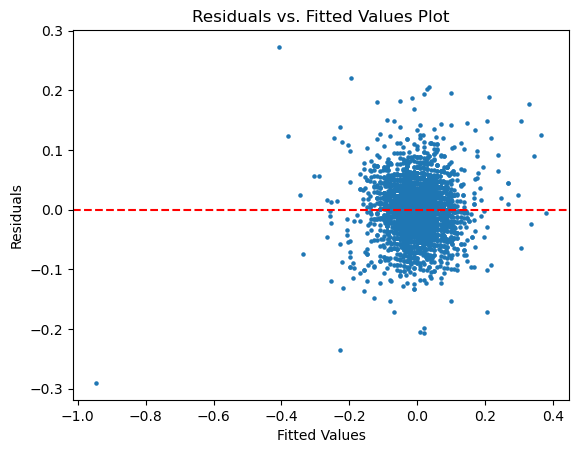

In [ ]:
plt.scatter(Y_predictions, residuals, s=5)
plt.axhline(y=0, color='r', linestyle='--')  
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot')
plt.show()

Then, we checked the nornality assumption of the residuals by plotting a histogram. Residuals seemed to approximately follow a normal distribution.

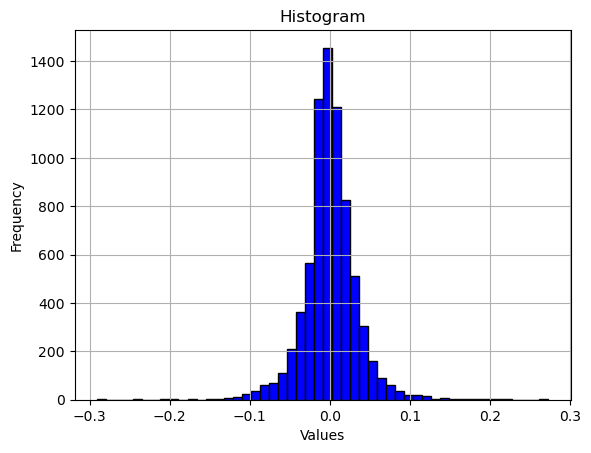

In [ ]:
plt.hist(residuals, bins=50, color='blue', edgecolor='black')
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Then, we drew a control chart of the residuals from 2018 to 2021. 

Text(0, 0.5, 'residuals')

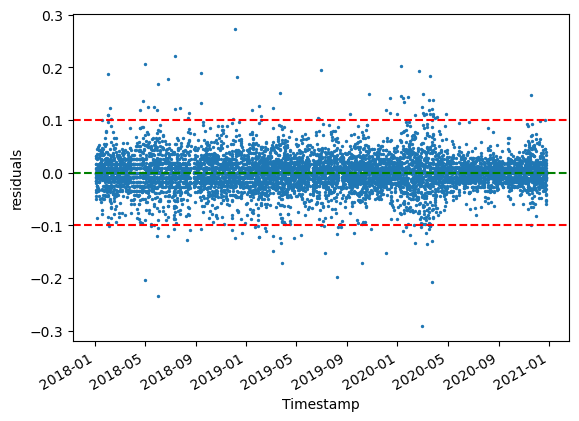

In [ ]:
LCL = mean - 3*std
UCL = mean + 3*std
plt.scatter(all_df.index,residuals,marker="o",s=2)
plt.gcf().autofmt_xdate()
plt.axhline(y = mean, color = 'g', linestyle = '--')
plt.axhline(y = UCL, color = 'r', linestyle = '--')#
plt.axhline(y = LCL, color = 'r', linestyle = '--')
plt.xlabel("Timestamp")
plt.ylabel("residuals")

Since there were out-of-control points, we omitted those points and redrew the control chart with new control limits and the remaining points.

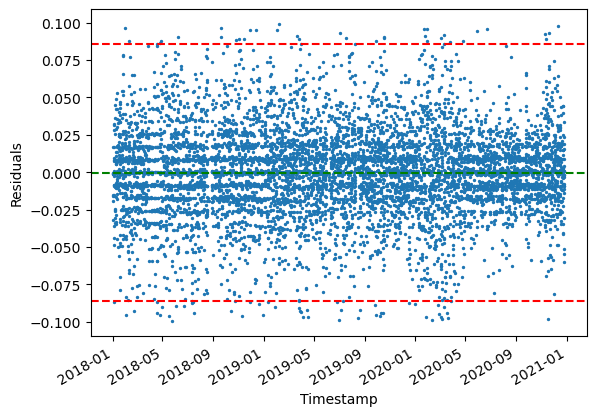

In [ ]:
remaining_residuals = residuals[(residuals >= LCL) & (residuals <= UCL)]
remaining_timestamps = all_df[(residuals >= LCL) & (residuals <= UCL)].index

new_mean = np.mean(remaining_residuals)
new_std = np.std(remaining_residuals)
new_CL = new_mean
new_UCL = new_mean + 3*new_std
new_LCL = new_mean - 3*new_std
plt.scatter(remaining_timestamps, remaining_residuals, marker="o", s=2)
plt.axhline(new_CL, color='g', linestyle='--')
plt.axhline(new_UCL, color='r', linestyle='--')
plt.axhline(new_LCL, color='r', linestyle='--')
plt.gcf().autofmt_xdate()
plt.xlabel("Timestamp")
plt.ylabel("Residuals")

plt.show()

We continued doing this until there were no out-of-control points. In other words, until the process was in control.

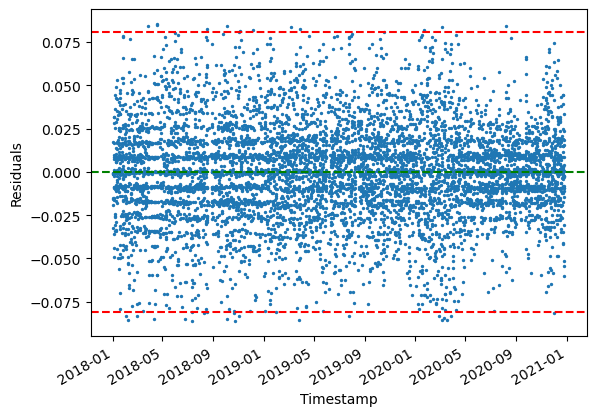

In [ ]:
remaining_residuals_2 = remaining_residuals[(remaining_residuals >= new_LCL) & (remaining_residuals <= new_UCL)]
remaining_timestamps_2 = remaining_timestamps[(remaining_residuals >= new_LCL) & (remaining_residuals <= new_UCL)]

new_mean_2 = np.mean(remaining_residuals_2)
new_std_2 = np.std(remaining_residuals_2)
new_CL_2 = new_mean_2
new_UCL_2 = new_mean_2 + 3*new_std_2
new_LCL_2 = new_mean_2 - 3*new_std_2
plt.scatter(remaining_timestamps_2, remaining_residuals_2, marker="o", s=2)
plt.axhline(new_CL_2, color='g', linestyle='--')
plt.axhline(new_UCL_2, color='r', linestyle='--')
plt.axhline(new_LCL_2, color='r', linestyle='--')
plt.gcf().autofmt_xdate()
plt.xlabel("Timestamp")
plt.ylabel("Residuals")

plt.show()

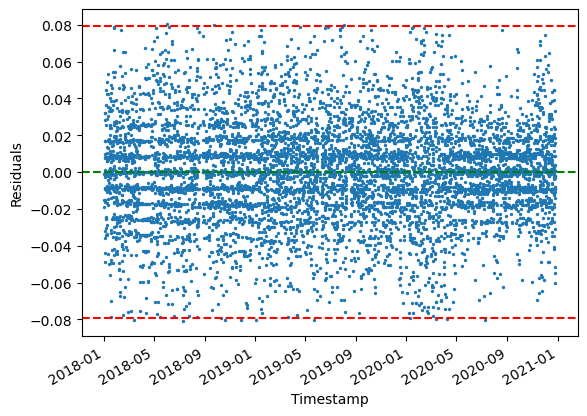

In [ ]:
remaining_residuals_3 = remaining_residuals_2[(remaining_residuals_2 >= new_LCL_2) & (remaining_residuals_2 <= new_UCL_2)]
remaining_timestamps_3 = remaining_timestamps_2[(remaining_residuals_2 >= new_LCL_2) & (remaining_residuals_2 <= new_UCL_2)]

new_mean_3 = np.mean(remaining_residuals_3)
new_std_3 = np.std(remaining_residuals_3)
new_CL_3 = new_mean_3
new_UCL_3 = new_mean_3 + 3*new_std_3
new_LCL_3 = new_mean_3 - 3*new_std_3
plt.scatter(remaining_timestamps_3, remaining_residuals_3, marker="o", s=2)
plt.axhline(new_CL_3, color='g', linestyle='--')
plt.axhline(new_UCL_3, color='r', linestyle='--')
plt.axhline(new_LCL_3, color='r', linestyle='--')
plt.gcf().autofmt_xdate()
plt.xlabel("Timestamp")
plt.ylabel("Residuals")

plt.show()

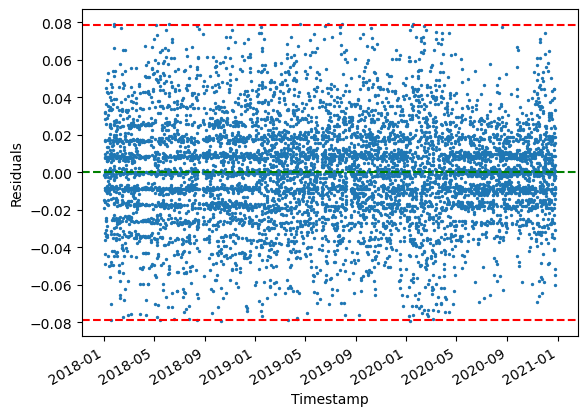

In [ ]:
remaining_residuals_4 = remaining_residuals_3[(remaining_residuals_3 >= new_LCL_3) & (remaining_residuals_3 <= new_UCL_3)]
remaining_timestamps_4 = remaining_timestamps_3[(remaining_residuals_3 >= new_LCL_3) & (remaining_residuals_3 <= new_UCL_3)]

new_mean_4 = np.mean(remaining_residuals_4)
new_std_4 = np.std(remaining_residuals_4)
new_CL_4 = new_mean_4
new_UCL_4 = new_mean_4 + 3*new_std_4
new_LCL_4 = new_mean_4 - 3*new_std_4
plt.scatter(remaining_timestamps_4, remaining_residuals_4, marker="o", s=2)
plt.axhline(new_CL_4, color='g', linestyle='--')
plt.axhline(new_UCL_4, color='r', linestyle='--')
plt.axhline(new_LCL_4, color='r', linestyle='--')
plt.gcf().autofmt_xdate()
plt.xlabel("Timestamp")
plt.ylabel("Residuals")

plt.show()

After we made sure that we drew the control chart of the in-control process from the historical data, we updated out control limits, and fitted a linear regression line to the 2021 data. We plotted the residuals of the 2021 data onto the control chart of the in-control process.

In [ ]:
CL =new_CL_4
UCL = new_UCL_4
LCL = new_LCL_4


Text(0, 0.5, 'residuals')

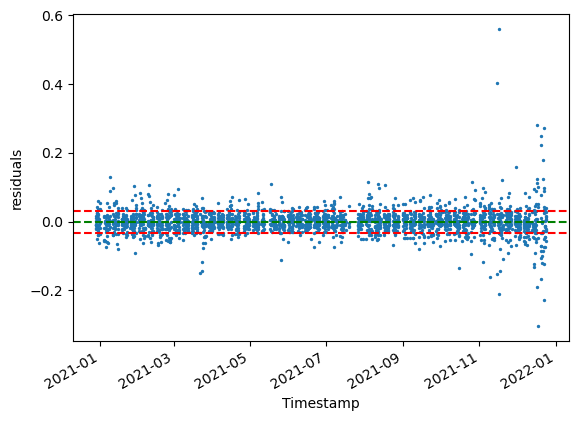

In [39]:
files_2021 = ["20201228_20210328_bist30.csv","20210329_20210627_bist30.csv","20210628_20210926_bist30.csv","20210927_20211226_bist30.csv"]
df_2021_list = []

for file in files_2021:
    df = pd.read_csv(file)
    df_2021_list.append(df)

df_2021 = pd.concat(df_2021_list, ignore_index=True)
df_2021["timestamp"] = pd.to_datetime(df_2021["timestamp"])
df_2021.set_index("timestamp", inplace=True)
df_2021 = df_2021.sort_values(by="timestamp")

stock_names = df_2021['short_name'].unique()
all_df_2021 = pd.DataFrame()
for stock in stock_names:
    stock_data = df_2021.loc[df_2021["short_name"] == stock].iloc[:,[0,1]]
    all_df_2021[stock] = stock_data["price"]

all_df_2021_diff = all_df_2021.diff().dropna()

akbnk_2021 = all_df_2021_diff["AKBNK"].values.reshape(-1,1)
garan_2021 = all_df_2021_diff["GARAN"].values.reshape(-1,1)

lr = LinearRegression()
lr.fit(akbnk_2021,garan_2021)
garan_predictions = lr.predict(akbnk_2021)
residuals_2021 = garan_2021 - garan_predictions



plt.scatter(all_df_2021_diff.index,residuals_2021,marker="o",s=2)
plt.gcf().autofmt_xdate()
plt.axhline(CL, color = 'g', linestyle = '--')
plt.axhline(UCL, color = 'r', linestyle = '--')#
plt.axhline(LCL, color = 'r', linestyle = '--')
plt.xlabel("Timestamp")
plt.ylabel("residuals")



Lastly, we calculated the return of the pairs trading. Then, we did the exact same steps for the second highly correlated pair we chose, "KOZAA" and "KOZAL".

In [ ]:
prices = all_df_2021[["AKBNK","GARAN"]]
signals = np.where(residuals_2021 < LCL, 1, np.where(residuals_2021 > UCL, -1, 0))

returns = np.zeros_like(signals, dtype=float)

for i in range(1, len(signals)):
    returns[i] = signals[i] * (prices.iloc[i-1]["AKBNK"] - prices.iloc[i-1]["GARAN"])


print(np.sum(returns))


30.039399999999993


In [29]:
X = all_df["KOZAA"].values.reshape(-1,1)
Y = all_df["KOZAL"].values.reshape(-1,1)

lr = LinearRegression()
lr.fit(X,Y)
Y_predictions = lr.predict(X)
residuals = Y - Y_predictions
mean = residuals.mean()
std = residuals.std()

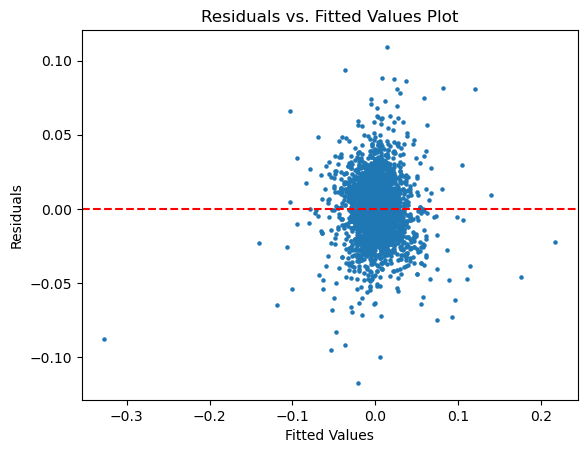

In [30]:
plt.scatter(Y_predictions, residuals, s=5)
plt.axhline(y=0, color='r', linestyle='--')  
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot')
plt.show()

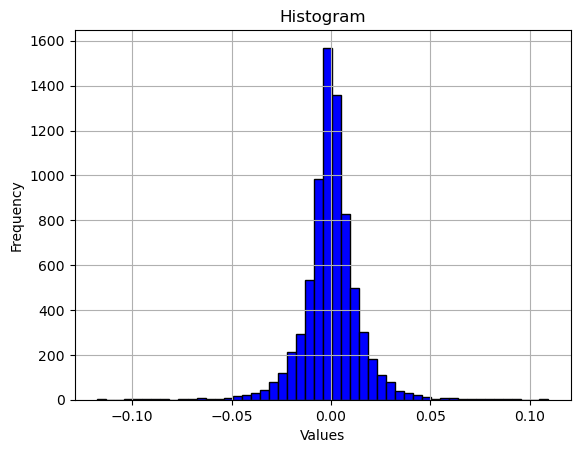

In [31]:
plt.hist(residuals, bins=50, color='blue', edgecolor='black')
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Text(0, 0.5, 'residuals')

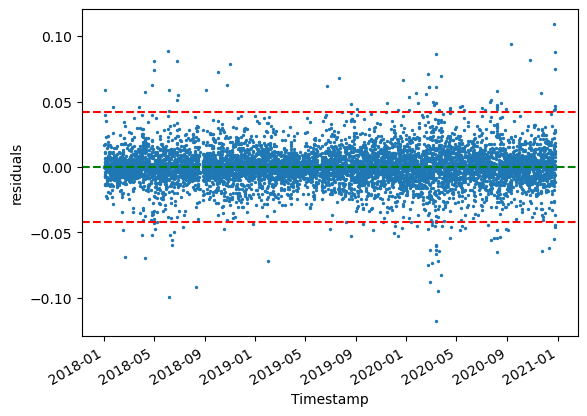

In [32]:
LCL = mean - 3*std
UCL = mean + 3*std
plt.scatter(all_df.index,residuals,marker="o",s=2)
plt.gcf().autofmt_xdate()
plt.axhline(y = mean, color = 'g', linestyle = '--')
plt.axhline(y = UCL, color = 'r', linestyle = '--')#
plt.axhline(y = LCL, color = 'r', linestyle = '--')
plt.xlabel("Timestamp")
plt.ylabel("residuals")

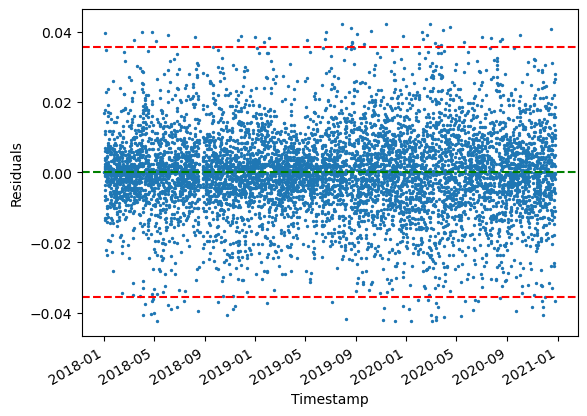

In [33]:
remaining_residuals = residuals[(residuals >= LCL) & (residuals <= UCL)]
remaining_timestamps = all_df[(residuals >= LCL) & (residuals <= UCL)].index

new_mean = np.mean(remaining_residuals)
new_std = np.std(remaining_residuals)
new_CL = new_mean
new_UCL = new_mean + 3*new_std
new_LCL = new_mean - 3*new_std
plt.scatter(remaining_timestamps, remaining_residuals, marker="o", s=2)
plt.axhline(new_CL, color='g', linestyle='--')
plt.axhline(new_UCL, color='r', linestyle='--')
plt.axhline(new_LCL, color='r', linestyle='--')
plt.gcf().autofmt_xdate()
plt.xlabel("Timestamp")
plt.ylabel("Residuals")

plt.show()

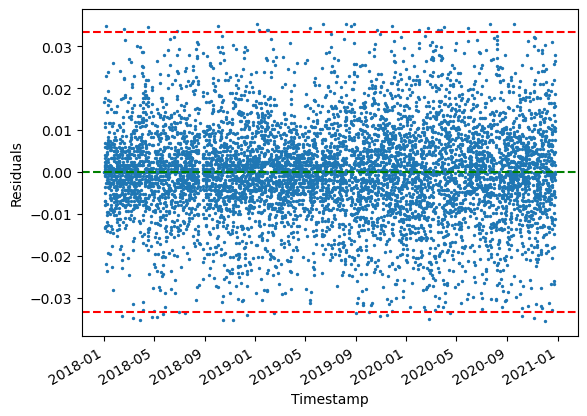

In [34]:
remaining_residuals_2 = remaining_residuals[(remaining_residuals >= new_LCL) & (remaining_residuals <= new_UCL)]
remaining_timestamps_2 = remaining_timestamps[(remaining_residuals >= new_LCL) & (remaining_residuals <= new_UCL)]

new_mean_2 = np.mean(remaining_residuals_2)
new_std_2 = np.std(remaining_residuals_2)
new_CL_2 = new_mean_2
new_UCL_2 = new_mean_2 + 3*new_std_2
new_LCL_2 = new_mean_2 - 3*new_std_2
plt.scatter(remaining_timestamps_2, remaining_residuals_2, marker="o", s=2)
plt.axhline(new_CL_2, color='g', linestyle='--')
plt.axhline(new_UCL_2, color='r', linestyle='--')
plt.axhline(new_LCL_2, color='r', linestyle='--')
plt.gcf().autofmt_xdate()
plt.xlabel("Timestamp")
plt.ylabel("Residuals")

plt.show()

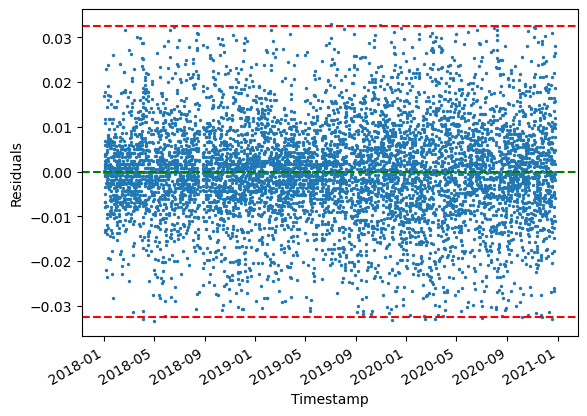

In [35]:
remaining_residuals_3 = remaining_residuals_2[(remaining_residuals_2 >= new_LCL_2) & (remaining_residuals_2 <= new_UCL_2)]
remaining_timestamps_3 = remaining_timestamps_2[(remaining_residuals_2 >= new_LCL_2) & (remaining_residuals_2 <= new_UCL_2)]

new_mean_3 = np.mean(remaining_residuals_3)
new_std_3 = np.std(remaining_residuals_3)
new_CL_3 = new_mean_3
new_UCL_3 = new_mean_3 + 3*new_std_3
new_LCL_3 = new_mean_3 - 3*new_std_3
plt.scatter(remaining_timestamps_3, remaining_residuals_3, marker="o", s=2)
plt.axhline(new_CL_3, color='g', linestyle='--')
plt.axhline(new_UCL_3, color='r', linestyle='--')
plt.axhline(new_LCL_3, color='r', linestyle='--')
plt.gcf().autofmt_xdate()
plt.xlabel("Timestamp")
plt.ylabel("Residuals")

plt.show()

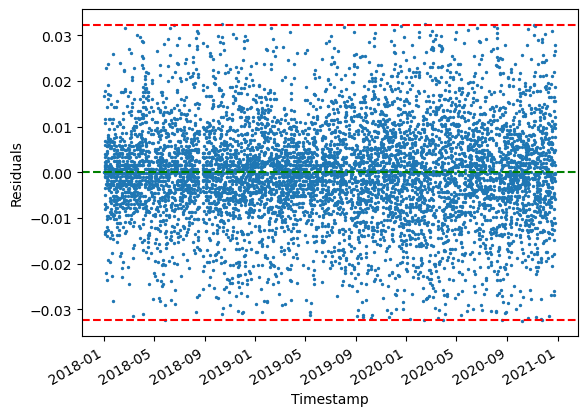

In [36]:
remaining_residuals_4 = remaining_residuals_3[(remaining_residuals_3 >= new_LCL_3) & (remaining_residuals_3 <= new_UCL_3)]
remaining_timestamps_4 = remaining_timestamps_3[(remaining_residuals_3 >= new_LCL_3) & (remaining_residuals_3 <= new_UCL_3)]

new_mean_4 = np.mean(remaining_residuals_4)
new_std_4 = np.std(remaining_residuals_4)
new_CL_4 = new_mean_4
new_UCL_4 = new_mean_4 + 3*new_std_4
new_LCL_4 = new_mean_4 - 3*new_std_4
plt.scatter(remaining_timestamps_4, remaining_residuals_4, marker="o", s=2)
plt.axhline(new_CL_4, color='g', linestyle='--')
plt.axhline(new_UCL_4, color='r', linestyle='--')
plt.axhline(new_LCL_4, color='r', linestyle='--')
plt.gcf().autofmt_xdate()
plt.xlabel("Timestamp")
plt.ylabel("Residuals")

plt.show()

In [37]:
CL =new_CL_4
UCL = new_UCL_4
LCL = new_LCL_4


Text(0, 0.5, 'residuals')

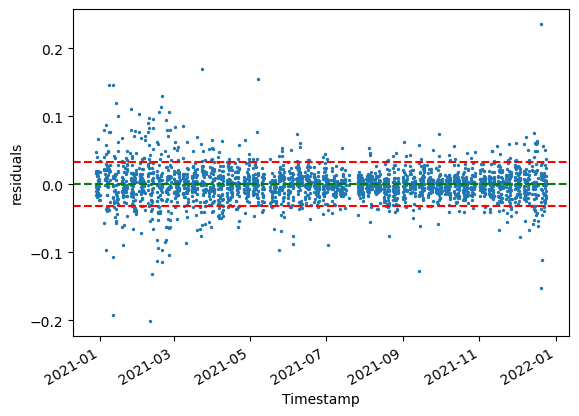

In [40]:
kozaa_2021 = all_df_2021_diff["KOZAA"].values.reshape(-1,1)
kozal_2021 = all_df_2021_diff["KOZAL"].values.reshape(-1,1)

lr = LinearRegression()
lr.fit(kozaa_2021,kozal_2021)
kozal_predictions = lr.predict(kozaa_2021)
residuals_2021 = kozal_2021 - kozal_predictions



plt.scatter(all_df_2021_diff.index,residuals_2021,marker="o",s=2)
plt.gcf().autofmt_xdate()
plt.axhline(CL, color = 'g', linestyle = '--')
plt.axhline(UCL, color = 'r', linestyle = '--')#
plt.axhline(LCL, color = 'r', linestyle = '--')
plt.xlabel("Timestamp")
plt.ylabel("residuals")



In [ ]:
prices = all_df_2021[["KOZAA","KOZAL"]]
signals = np.where(residuals_2021 < LCL, 1, np.where(residuals_2021 > UCL, -1, 0))

returns = np.zeros_like(signals, dtype=float)

for i in range(1, len(signals)):
    returns[i] = signals[i] * (prices.iloc[i-1]["KOZAA"] - prices.iloc[i-1]["KOZAL"])


print(np.sum(returns))